In [29]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import time
from pandas import ExcelWriter
from pandas import ExcelFile
from pprint import pprint
from scipy.stats import linregress
from datetime import timedelta
from mpl_toolkits.basemap import Basemap
from matplotlib.pyplot import figure
import shapely.geometry
import pyproj
from config import api_key

# Reduce number of categories by combining

In [2]:
metriclist = ['BOV']
new_categories = {'fashion_clothing': ['perfumery', 'luggage_accessories','watches_gifts','fashion_underwear_beach','fashion_bags_accessories','fashion_shoes','fashion_male_clothing','fashion_sport','fashio_female_clothing','fashion_childrens_clothes'],
                  'home_furniture': ['housewares','art','arts_and_craftmanship','furniture_decor','office_furniture','bed_bath_table','home_confort','furniture_bedroom','kitchen_dining_laundry_garden_furniture','home_comfort_2','furniture_mattress_and_upholstery'],
                  'construction_tools': ['garden_tools','construction_tools_construction','construction_tools_lights','construction_tools_garden','construction_tools_safety','home_construction','construction_tools_tools'],
                  'electronics': ['computers_accessories','telephony','electionics','cds_dvds_musicals','consoles_games','audio','tablets_printing_image','computers','dvds_blu_ray','music'],
                  'food_drink': ['food','drinks','food_drink','la_cuisine'],
                  'books': ['books_general_interest','books_imported','books_technical'],
                  'appliances': ['air_conditioning','small_appliances','home_appliances','home_appliances_2','small_appliances_home_oven_and_coffee'],
                  'auto': ['auto'],
                  'industry':['agro_industry_and_commerce','industry_commerce_and_business'],
                  'other':['pet_shop','stationary','toys','baby','cool_stuff','sports_leisure','diapers_and_hygeine','signaling_and_security','party_supplies','cine_photo','market_place','musical_instruments','christmas_supplies']}

# Read in files and merge into a single dataframe

In [3]:
##CAN RUN OR JUST COMMENT OUT AND IMPORT FROM CSV TO DF IN NEXT CELL 
fileordprod = "./Data/brazilian-ecommerce/olist_order_items_dataset.csv"
fileordcusttime = "./Data/brazilian-ecommerce/olist_orders_dataset.csv"
fileprodcat = "./Data/brazilian-ecommerce/olist_products_dataset.csv"
fileprodtransl = "./Data/brazilian-ecommerce/product_category_name_translation.csv"
filecustzip = "./Data/brazilian-ecommerce/olist_customers_dataset.csv"
filezipcoord = "./Data/brazilian-ecommerce/olist_geolocation_dataset.csv"

ordprod = pd.read_csv(fileordprod)
ordcusttime= pd.read_csv(fileordcusttime)
prodcat = pd.read_csv(fileprodcat)
prodtransl = pd.read_csv(fileprodtransl)
custzip = pd.read_csv(filecustzip)[['customer_id','customer_zip_code_prefix']]
zipcoord = pd.read_csv(filezipcoord)[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']]

zipcoord = zipcoord.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'}).drop_duplicates(subset = 'customer_zip_code_prefix')

mergedf = pd.merge(ordcusttime, ordprod, on = 'order_id',how= 'left')
mergedf = pd.merge(mergedf, prodcat, on = 'product_id', how = 'left')
mergedf = pd.merge(mergedf, prodtransl, on = 'product_category_name', how = 'left')
mergedf = pd.merge(mergedf, custzip, on = 'customer_id', how = 'left')
mergedf = pd.merge(mergedf, zipcoord, on = 'customer_zip_code_prefix' , how = 'left')

renamecolumns = {
    'order_purchase_timestamp': 'order_time',
    'product_category_name_english': 'category'
}
mergedf = mergedf.rename(columns = renamecolumns)

# Format Dates and set target date

In [4]:
#minus one day
mergedf["date_time"]= pd.to_datetime(mergedf['order_time']) - timedelta(days=1)

#converted to MM/YY Format
mergedf['YYYY'] = pd.DatetimeIndex(mergedf['date_time']).year
mergedf['MM'] = pd.DatetimeIndex(mergedf['date_time']).month
mergedf['month'] = pd.to_datetime(mergedf['date_time'])
mergedf['day'] = mergedf['month'].dt.strftime('%m/%d/%y')
mergedf['month'] = mergedf['month'].dt.strftime('%m/%y')

# Remove outlier

In [5]:
#Rid of black friday
mergedf = mergedf.loc[mergedf['day'] != '11/23/17']

# Create longitude/latitude grid of equal sizes

In [6]:
# Set up projections
p_ll = pyproj.Proj(init='epsg:4326')
p_mt = pyproj.Proj(init='epsg:3857') # metric; same as EPSG:900913

maxlat = max(mergedf['geolocation_lat'])
minlat = min(mergedf['geolocation_lat'])
maxlon = max(mergedf['geolocation_lng'])
minlon = min(mergedf['geolocation_lng'])


# Create corners of rectangle to be transformed to a grid
nw = shapely.geometry.Point((-85.0 ,-72.0))
se = shapely.geometry.Point((9.0,50.0))

stepsize = 100000

# Project corners to target projection
s = pyproj.transform(p_ll, p_mt, nw.x, nw.y) # Transform NW point to 3857
e = pyproj.transform(p_ll, p_mt, se.x, se.y) # .. same for SE

# Iterate over 2D area
gridpoints = []
x = s[0]
while x < e[0]:
    y = s[1]
    while y < e[1]:
        p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

lngbin = []
latbin = []

for p in gridpoints:
    lngbin.append(p.x)
    latbin.append(p.y)


lngbin = list(set(lngbin))
latbin = list(set(latbin))
    
lngbin.sort()
latbin.sort()

lngbinlabel = []
latbinlabel = []

for lng in range(0, len(lngbin) - 1):
    lngbinlabel.append(lngbin[lng] + (lngbin[lng+1] - lngbin[lng])/2)
        
for lat in range(0, len(latbin) - 1):
    latbinlabel.append(latbin[lat] + (latbin[lat+1] - latbin[lat])/2)
    
mergedf['lngbin'] = pd.cut(mergedf['geolocation_lng'], lngbin, labels=lngbinlabel)
mergedf['latbin'] = pd.cut(mergedf['geolocation_lat'], latbin, labels=latbinlabel)

# Get BOV data from Quandl API and merge with DF

In [31]:
urlBOV = "https://www.quandl.com/api/v3/datasets/BCB/7.json?api_key=" + api_key
responseBOV = requests.get(urlBOV).json()


BOV_df = pd.DataFrame(responseBOV['dataset']['data'])

BOV_df = BOV_df.rename(index=str, columns={0: "day", 1: "BOV"})

BOV_df['day'] = pd.to_datetime(BOV_df['day'])
BOV_df['day'] = BOV_df['day'].dt.strftime('%m/%d/%y')
BOV_df['BOV'] = pd.to_numeric(BOV_df['BOV'])
BOV_df = BOV_df.sort_values(by = 'day', ascending = True)
mergedf = pd.merge(mergedf, BOV_df, on = 'day', how = 'left')

# Graph total spent for each category

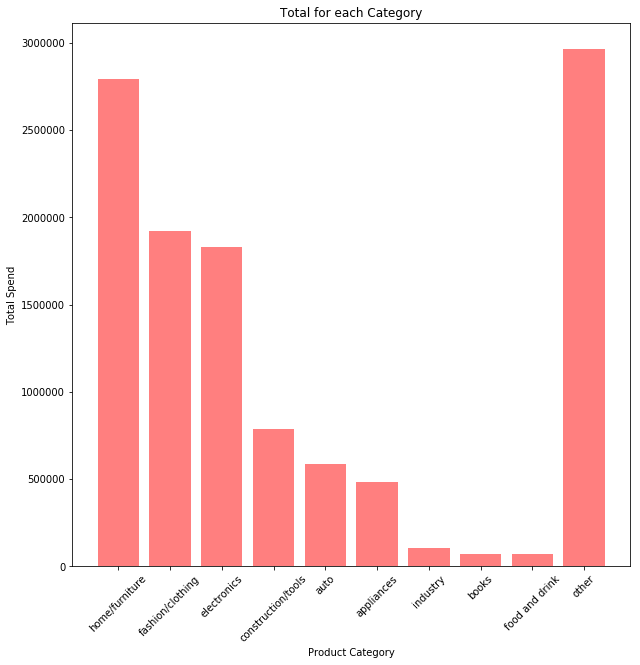

In [8]:
new_dict = {}
for key,valuelist in new_categories.items():
    for v in valuelist:
        new_dict[v] = key

mergedf['category'] = mergedf.category.replace(new_dict)
mergedf.to_csv('./Data/mergedf.csv')
mergedf = pd.read_csv('./Data/mergedf.csv')
mergedf.head()

home_furniture = mergedf['price'][mergedf['category']=='home_furniture'].sum()
fashion_clothing = mergedf['price'][mergedf['category']=='fashion_clothing'].sum()
construction_tools = mergedf['price'][mergedf['category']=='construction_tools'].sum()
electronics = mergedf['price'][mergedf['category']=='electronics'].sum()
food_drink = mergedf['price'][mergedf['category']=='food_drink'].sum()
books = mergedf['price'][mergedf['category']=='books'].sum()
appliances = mergedf['price'][mergedf['category']=='appliances'].sum()

auto = mergedf['price'][mergedf['category']=='auto'].sum()
industry = mergedf['price'][mergedf['category']=='industry'].sum()
other = mergedf['price'][mergedf['category']=='other'].sum()


total_spend = home_furniture + fashion_clothing + construction_tools + electronics + food_drink + books + appliances + auto + industry + other

category_spend = {home_furniture:'home_furniture',
                        fashion_clothing:'fashion_clothing',
                        construction_tools:'construction_tools',
                        electronics:'electronics',
                        food_drink:'food_drink',
                        books:'books',
                        appliances:'appliances',
                        auto:'auto',
                        appliances:'industry',
                        other:'other'
                       }

x_axis = ['home/furniture', 'fashion/clothing', 'electronics', 'construction/tools', 'auto', 'appliances', 'industry', 'books', 'food and drink', 'other']
sizes =[home_furniture, fashion_clothing, electronics, construction_tools, auto, appliances, industry, books, food_drink, other]
fig = plt.figure(figsize=(10, 10))
plt.bar(x_axis, sizes, color='r', alpha=0.5, align="center", orientation = 'vertical')
plt.xticks(rotation = 45)
# Save Figure

plt.title("Total for each Category")
plt.xlabel("Product Category")
plt.ylabel("Total Spend")
plt.savefig("./Graphs/total_spend.png")
plt.show()

# Create image/graph with total sales (for each category) visualized for each grid square. Second Graph for each category scales the sales within each category.

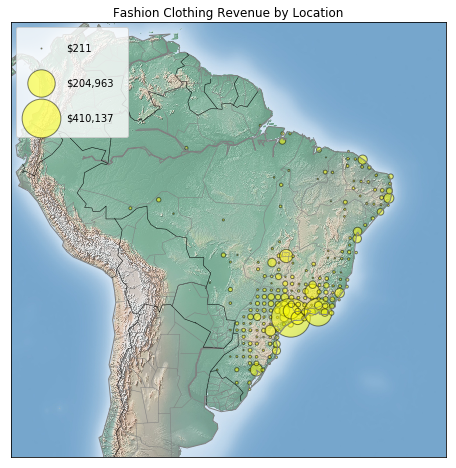

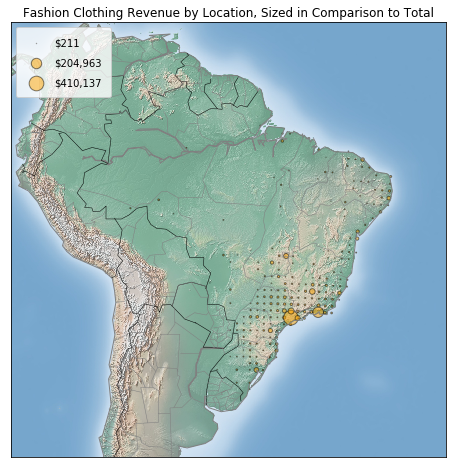

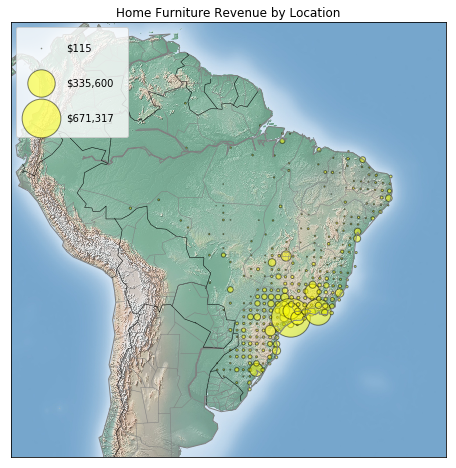

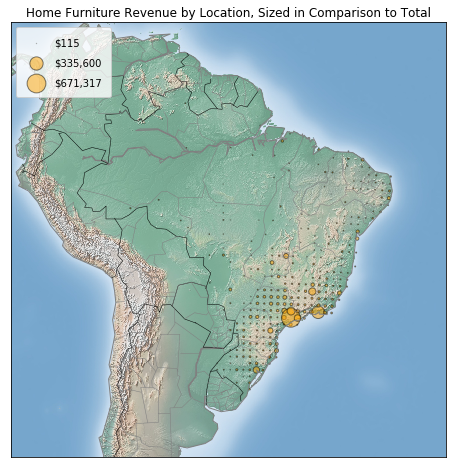

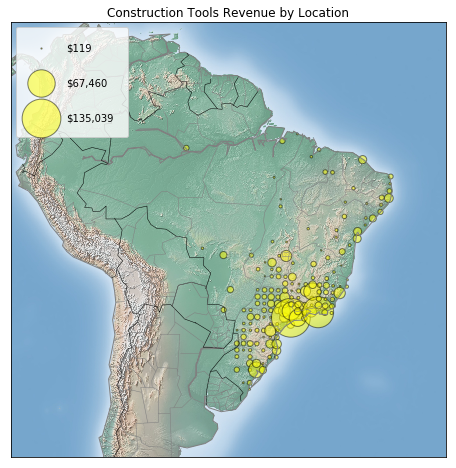

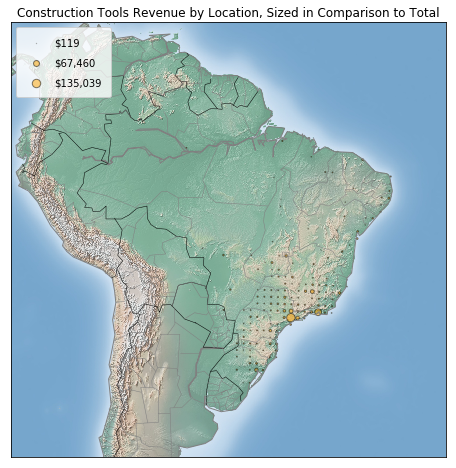

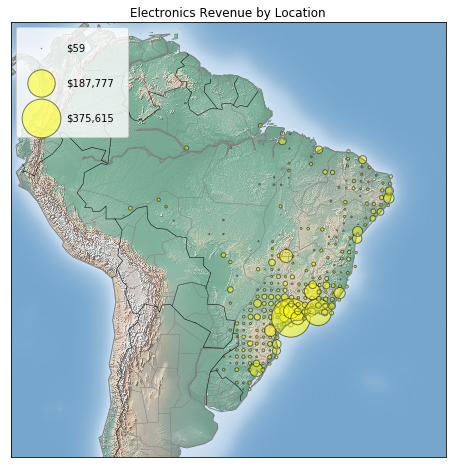

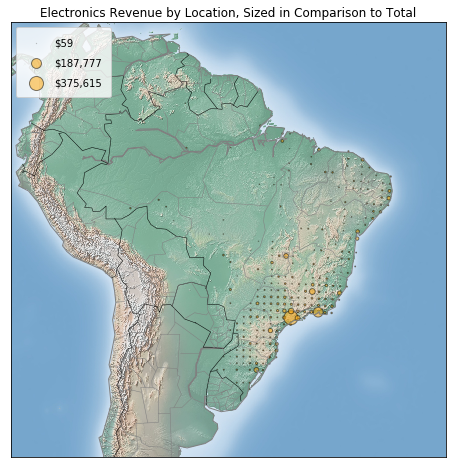

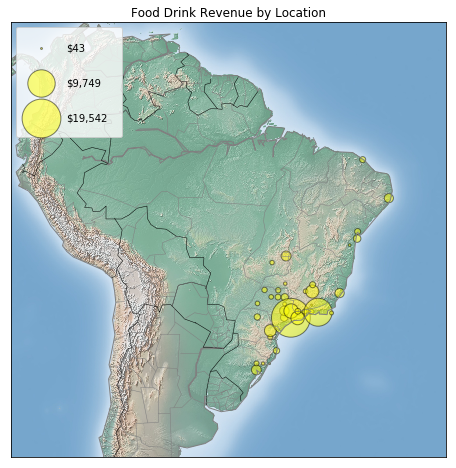

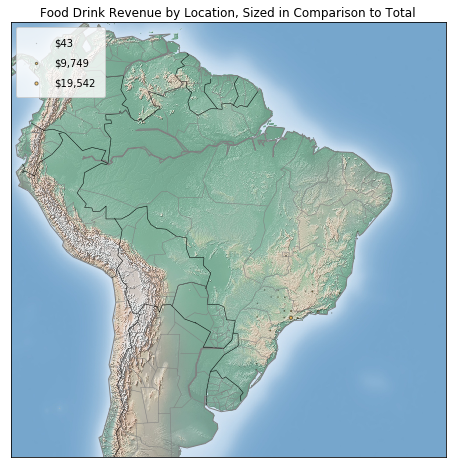

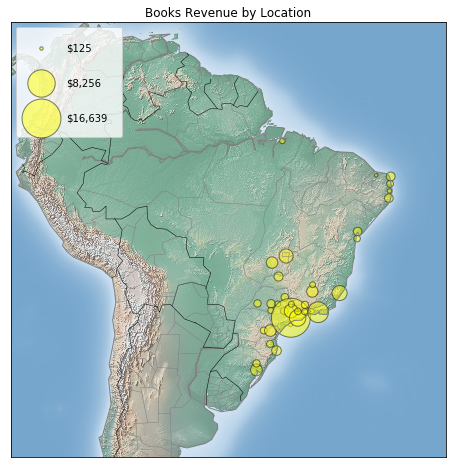

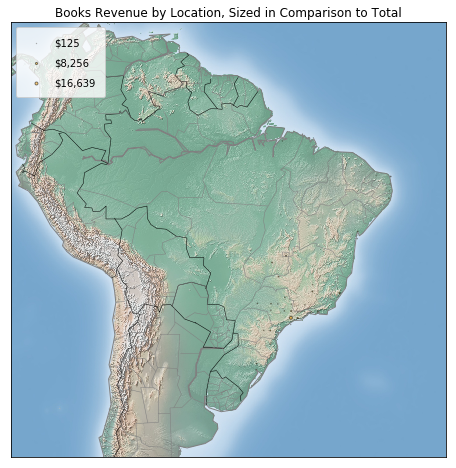

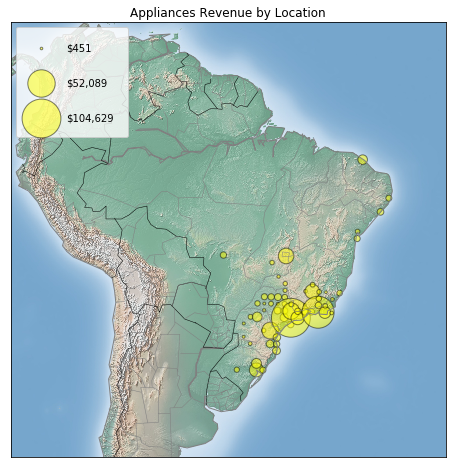

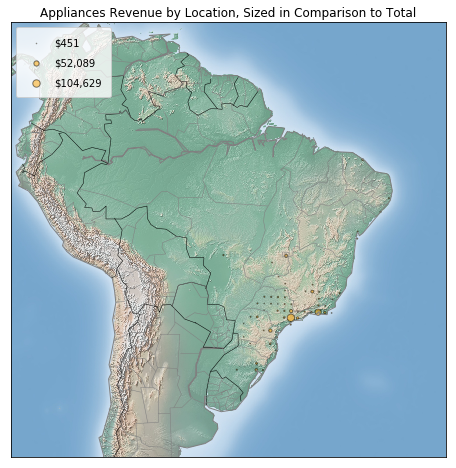

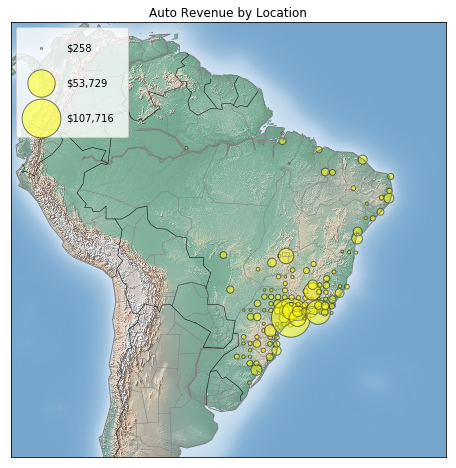

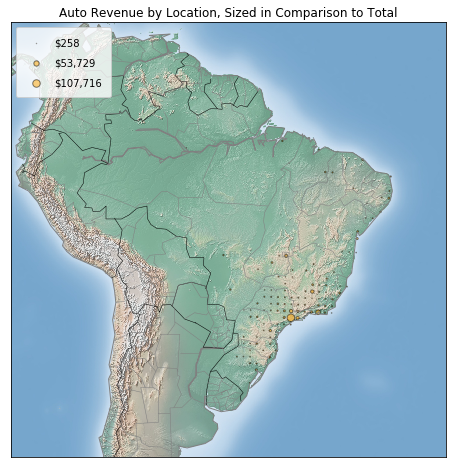

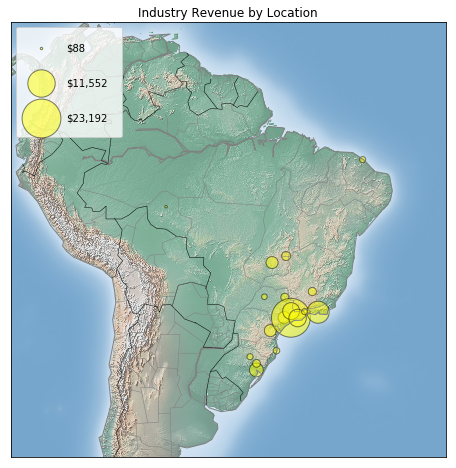

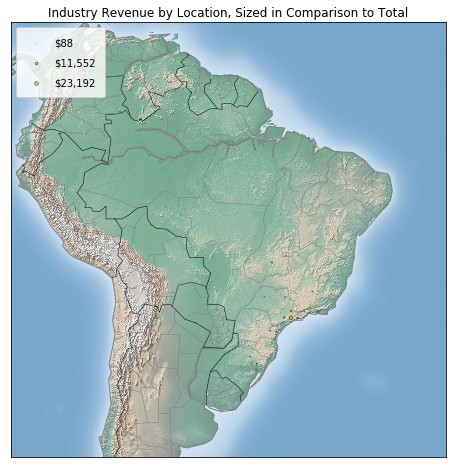

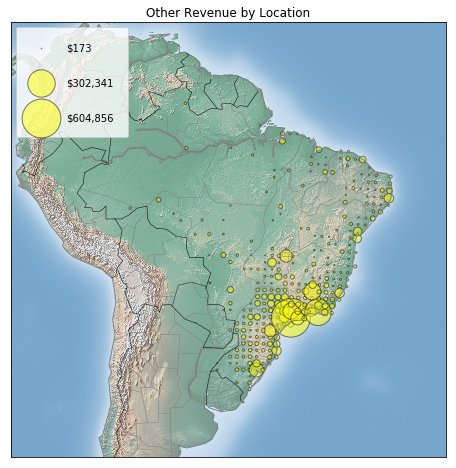

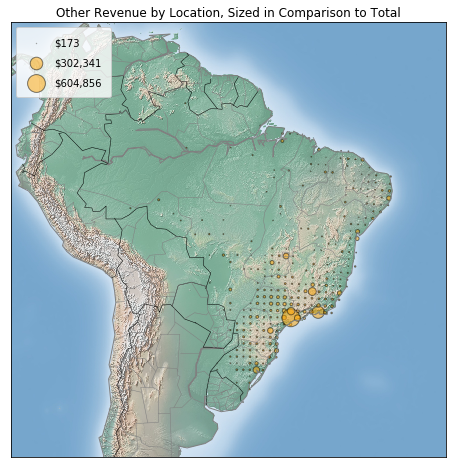

In [9]:
groupdf = mergedf.groupby(['lngbin', 'latbin'])
groupdf = groupdf.sum()
groupdf = groupdf.loc[groupdf['price'].isnull() == False]
groupdf = groupdf.loc[groupdf['order_item_id'] > 2]
groupdf = groupdf.reset_index()

minlng = min(groupdf['lngbin'])
maxlng = max(groupdf['lngbin'])
minlat = min(groupdf['latbin'])
maxlat = max(groupdf['latbin'])
marginlng = (max(groupdf['lngbin'])-min(groupdf['lngbin']))/10
marginlat = (max(groupdf['latbin'])-min(groupdf['latbin']))/10
dividebytotal = (max(groupdf['price']) - min(groupdf['price']))/1500

for cat in new_categories.keys():
    
    ###COMPARED TO SELF###
    groupdf = mergedf.groupby(['lngbin', 'latbin', 'category'])
    groupdf = groupdf.sum()
    groupdf = groupdf.loc[groupdf['price'].isnull() == False]
    groupdf = groupdf.loc[groupdf['order_item_id'] > 5]
    groupdf = groupdf.reset_index()
    
    groupdf = groupdf.loc[groupdf['category'] == cat]
    
    dividebyeach = (max(groupdf['price']) - min(groupdf['price']))/1500
    
    #Create Map
    lon = list(groupdf['lngbin'])
    lat = list(groupdf['latbin'])
    revenue = list(groupdf['price']/dividebyeach)

    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', resolution='c', 
                lat_0=-14.1, lon_0=-55.2,
                width=6000000, height=6000000)
    m.shadedrelief()
    m.drawcoastlines(color='gray')
    m.drawcountries(color='black')
    m.drawstates(color='gray')
    m.scatter(lon, lat, latlon=True, s=revenue, alpha=0.5, edgecolor = 'black', color = 'yellow')
    
    #LEGEND
    marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebyeach)
    marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebyeach)
    marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebyeach)
    legend_markers = [marker1, marker2, marker3]
    labels = [
        '$' + str("{:,}".format(int(groupdf['price'].min()))),
        '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
        '$' + str("{:,}".format(int(groupdf['price'].max())))
        ]
    leg = plt.legend(handles=legend_markers, labels=labels, loc='upper left',
        scatterpoints=1, labelspacing = 2.5, borderpad = 1.5, handletextpad = 1.5)
    LH = leg.legendHandles
    LH[0].set_color('yellow')
    LH[1].set_color('yellow')
    LH[0].set_alpha(0.5)
    LH[1].set_alpha(0.5)
    LH[0].set_edgecolor('black')
    LH[1].set_edgecolor('black')
    LH[2].set_color('yellow')
    LH[2].set_alpha(0.5)
    LH[2].set_edgecolor('black')
    plt.title(f'{cat.replace("_", " ").title()} Revenue by Location')
    plt.savefig(f'./Graphs/{cat.replace("_", " ").title()} Revenue by Location.png')
    plt.show()
    
    ###COMPARED TO TOTAL###
    
    lon = list(groupdf['lngbin'])
    lat = list(groupdf['latbin'])
    revenue = list(groupdf['price']/dividebytotal)

    #Create map
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', resolution='c', 
                lat_0=-14.1, lon_0=-55.2,
                width=6000000, height=6000000)
    m.shadedrelief()
    m.drawcoastlines(color='gray')
    m.drawcountries(color='black')
    m.drawstates(color='gray')
    m.scatter(lon, lat, latlon=True, s=revenue, alpha=0.5, edgecolor = 'black', color = 'orange')
    
    #LEGEND
    marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebytotal)
    marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebytotal)
    marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebytotal)
    legend_markers = [marker1, marker2, marker3]
    labels = [
        '$' + str("{:,}".format(int(groupdf['price'].min()))),
        '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
        '$' + str("{:,}".format(int(groupdf['price'].max())))
        ]
    leg = plt.legend(handles=legend_markers, labels=labels, loc='upper left',
        scatterpoints=1, labelspacing = 1, borderpad = 1)
    LH = leg.legendHandles
    LH[0].set_color('orange')
    LH[1].set_color('orange')
    LH[0].set_alpha(0.5)
    LH[1].set_alpha(0.5)
    LH[0].set_edgecolor('black')
    LH[1].set_edgecolor('black')
    LH[2].set_color('orange')
    LH[2].set_alpha(0.5)
    LH[2].set_edgecolor('black')
    plt.title(f'{cat.replace("_", " ").title()} Revenue by Location, Sized in Comparison to Total')
    plt.savefig(f'./Graphs/{cat.replace("_", " ").title()} Revenue by Location, Sized in Comparison to Total.png')
    
    plt.show()

# Create image/graph with total sales visualized for each grid square

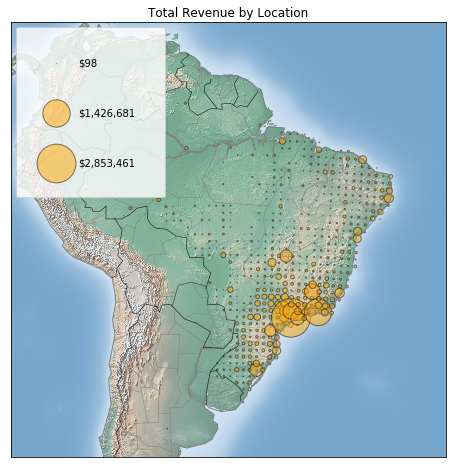

In [10]:
###TOTAL###
mergedf = pd.read_csv('./Data/mergedf.csv')
groupdf = mergedf.groupby(['lngbin', 'latbin'])
groupdf = groupdf.sum()
groupdf = groupdf.loc[groupdf['price'].isnull() == False]
groupdf = groupdf.loc[groupdf['order_item_id'] > 2]
groupdf = groupdf.reset_index()

minlng = min(groupdf['lngbin'])
maxlng = max(groupdf['lngbin'])
minlat = min(groupdf['latbin'])
maxlat = max(groupdf['latbin'])
marginlng = (max(groupdf['lngbin'])-min(groupdf['lngbin']))/10
marginlat = (max(groupdf['latbin'])-min(groupdf['latbin']))/10
dividebytotal = (max(groupdf['price']) - min(groupdf['price']))/1500


groupdf = mergedf.groupby(['lngbin', 'latbin'])
groupdf = groupdf.sum()
groupdf = groupdf.loc[groupdf['price'].isnull() == False]
groupdf = groupdf.loc[groupdf['order_item_id'] > 2]
groupdf = groupdf.reset_index()

lon = list(groupdf['lngbin'])
lat = list(groupdf['latbin'])
revenue = list(groupdf['price']/dividebytotal)

#Create Map
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='c', 
            lat_0=-14.1, lon_0=-55.2,
            width=6000000, height=6000000)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
m.scatter(lon, lat, latlon=True, s=revenue, alpha=0.5, edgecolor = 'black', color = 'orange')


# 3. create colorbar and legend
marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebytotal)
marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebytotal)
marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebytotal)
legend_markers = [marker1, marker2, marker3]
labels = [
    '$' + str("{:,}".format(int(groupdf['price'].min()))),
    '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
    '$' + str("{:,}".format(int(groupdf['price'].max())))
    ]
leg = plt.legend(handles=legend_markers, labels=labels, loc='upper left',
    scatterpoints=1, labelspacing = 4, borderpad = 3, handletextpad = 1.25)
LH = leg.legendHandles
LH[0].set_color('orange')
LH[1].set_color('orange')
LH[0].set_alpha(0.5)
LH[1].set_alpha(0.5)
LH[0].set_edgecolor('black')
LH[1].set_edgecolor('black')
LH[2].set_color('orange')
LH[2].set_alpha(0.5)
LH[2].set_edgecolor('black')

plt.title('Total Revenue by Location')
plt.savefig('./Graphs/Total Revenue by Location.png')

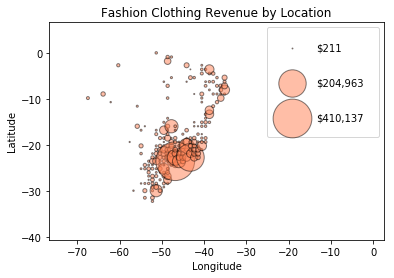

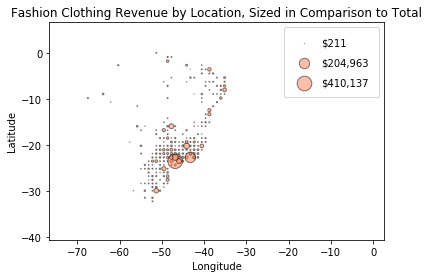

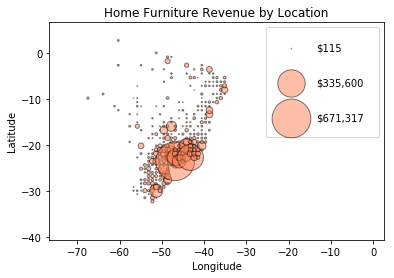

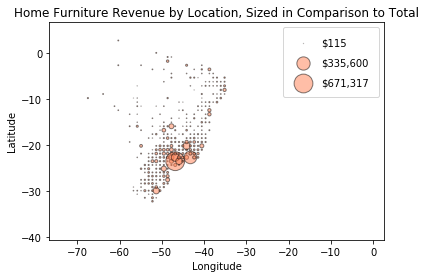

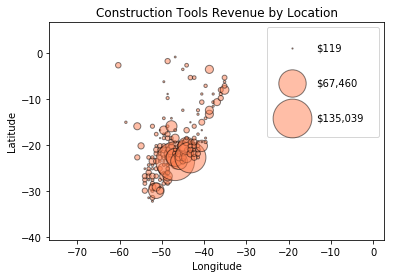

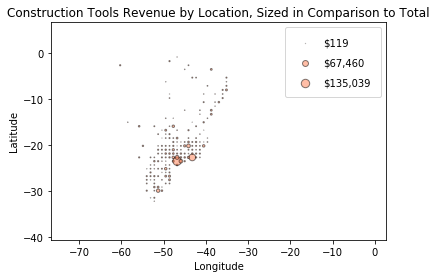

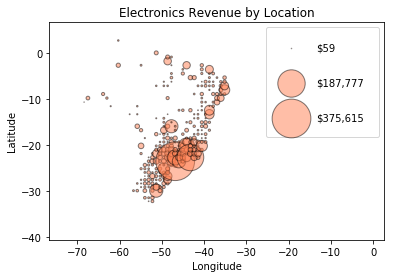

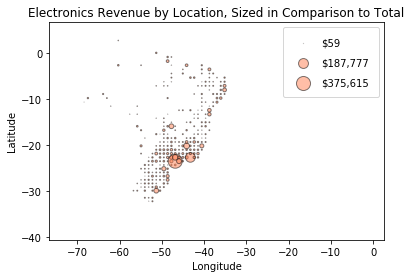

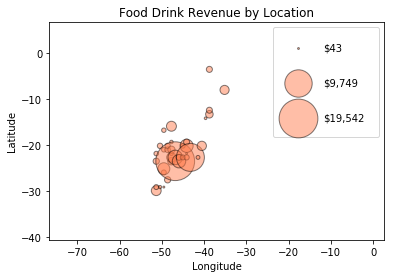

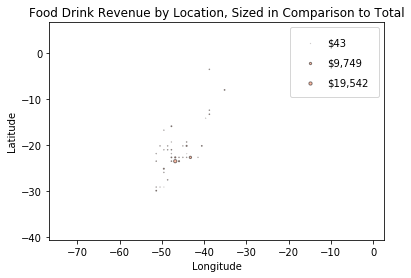

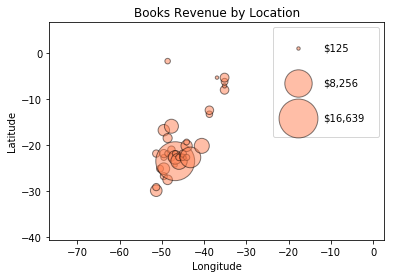

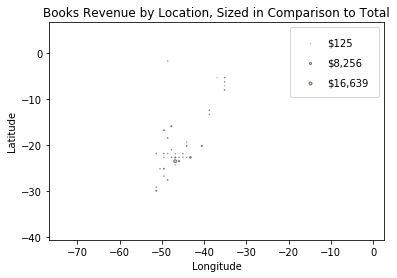

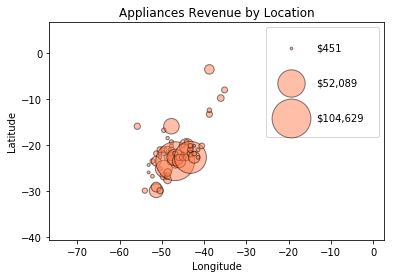

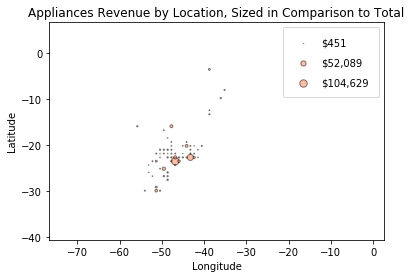

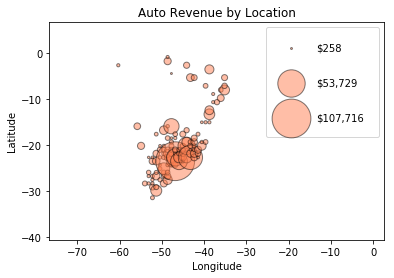

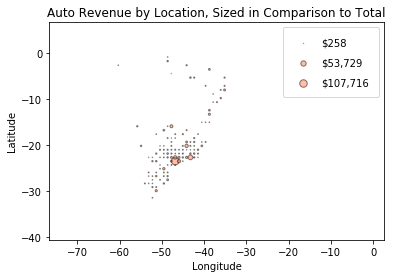

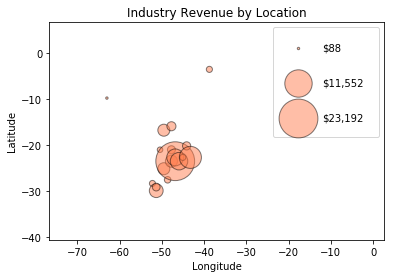

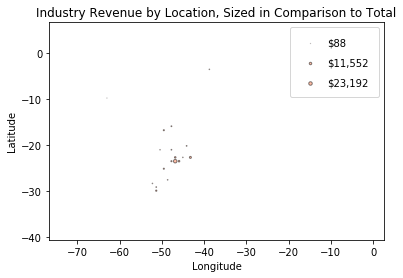

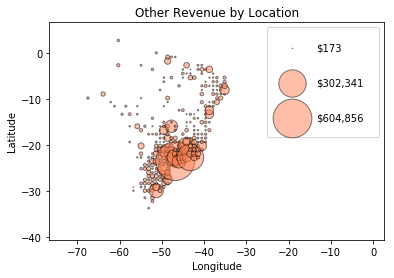

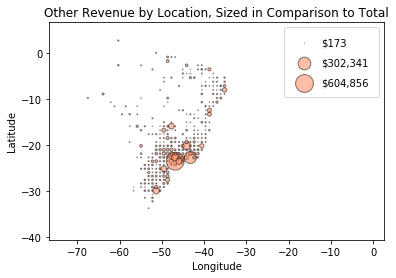

In [11]:
###SAME AS GRAPHS ABOVE BUT NOT USING BASEMAP

mergedf = pd.read_csv('./Data/mergedf.csv')
groupdf = mergedf.groupby(['lngbin', 'latbin'])
groupdf = groupdf.sum()
groupdf = groupdf.loc[groupdf['price'].isnull() == False]
groupdf = groupdf.loc[groupdf['order_item_id'] > 2]
groupdf = groupdf.reset_index()

minlng = min(groupdf['lngbin'])
maxlng = max(groupdf['lngbin'])
minlat = min(groupdf['latbin'])
maxlat = max(groupdf['latbin'])
marginlng = (max(groupdf['lngbin'])-min(groupdf['lngbin']))/10
marginlat = (max(groupdf['latbin'])-min(groupdf['latbin']))/10
dividebytotal = (max(groupdf['price']) - min(groupdf['price']))/1500

for cat in new_categories.keys():
    
    ###COMPARED TO SELF###
    groupdf = mergedf.groupby(['lngbin', 'latbin', 'category'])
    groupdf = groupdf.sum()
    groupdf = groupdf.loc[groupdf['price'].isnull() == False]
    groupdf = groupdf.loc[groupdf['order_item_id'] > 5]
    groupdf = groupdf.reset_index()
    
    groupdf = groupdf.loc[groupdf['category'] == cat]
    
    dividebyeach = (max(groupdf['price']) - min(groupdf['price']))/1500
    plt.scatter(groupdf['lngbin'], groupdf['latbin'], color="coral", edgecolor="black", alpha = 0.5,marker="o", s=groupdf['price']/dividebyeach)
    plt.xlim(minlng - marginlng, maxlng + 10 * marginlng)
    plt.ylim(minlat - marginlat, maxlat  + 1 * marginlat)
    
    #LEGEND
    marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebyeach)
    marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebyeach)
    marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebyeach)
    legend_markers = [marker1, marker2, marker3]
    labels = [
        '$' + str("{:,}".format(int(groupdf['price'].min()))),
        '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
        '$' + str("{:,}".format(int(groupdf['price'].max())))
        ]
    leg = plt.legend(handles=legend_markers, labels=labels, loc='upper right',
        scatterpoints=1, labelspacing = 2.5, borderpad = 1.5, handletextpad = 1.5)
    LH = leg.legendHandles
    LH[0].set_color('coral')
    LH[1].set_color('coral')
    LH[0].set_alpha(0.5)
    LH[1].set_alpha(0.5)
    LH[0].set_edgecolor('black')
    LH[1].set_edgecolor('black')
    LH[2].set_color('coral')
    LH[2].set_alpha(0.5)
    LH[2].set_edgecolor('black')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{cat.replace("_", " ").title()} Revenue by Location')
    plt.savefig(f'./Graphs/{cat.replace("_", " ").title()} Revenue by Location.png')
    plt.show()
    
    ###COMPARED TO TOTAL###
    
    plt.scatter(groupdf['lngbin'], groupdf['latbin'], color="coral", edgecolor="black", alpha = 0.5,marker="o", s=groupdf['price']/dividebytotal)
    plt.xlim(minlng - marginlng, maxlng + 10 * marginlng)
    plt.ylim(minlat - marginlat, maxlat  + 1 * marginlat)
    
    #LEGEND
    marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebytotal)
    marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebytotal)
    marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebytotal)
    legend_markers = [marker1, marker2, marker3]
    labels = [
        '$' + str("{:,}".format(int(groupdf['price'].min()))),
        '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
        '$' + str("{:,}".format(int(groupdf['price'].max())))
        ]
    leg = plt.legend(handles=legend_markers, labels=labels, loc='upper right',
        scatterpoints=1, labelspacing = 1, borderpad = 1)
    LH = leg.legendHandles
    LH[0].set_color('coral')
    LH[1].set_color('coral')
    LH[0].set_alpha(0.5)
    LH[1].set_alpha(0.5)
    LH[0].set_edgecolor('black')
    LH[1].set_edgecolor('black')
    LH[2].set_color('coral')
    LH[2].set_alpha(0.5)
    LH[2].set_edgecolor('black')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{cat.replace("_", " ").title()} Revenue by Location, Sized in Comparison to Total')
    #plt.savefig(f'./Graphs/{cat.replace("_", " ").title()} Revenue by Location, Sized in Comparison to Total.png')
    
    plt.show()

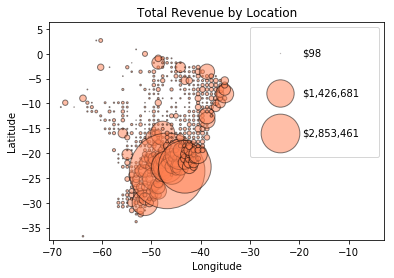

In [12]:
#SAME AS GRAPHS ABOVE BUT NOT USING BASEMAP

##TOTAL###
mergedf = pd.read_csv('./Data/mergedf.csv')
minlng = min(groupdf['lngbin'])
maxlng = max(groupdf['lngbin'])
minlat = min(groupdf['latbin'])
maxlat = max(groupdf['latbin'])
marginlng = (max(groupdf['lngbin'])-min(groupdf['lngbin']))/10
marginlat = (max(groupdf['latbin'])-min(groupdf['latbin']))/10


groupdf = mergedf.groupby(['lngbin', 'latbin'])
groupdf = groupdf.sum()
groupdf = groupdf.loc[groupdf['price'].isnull() == False]
groupdf = groupdf.loc[groupdf['order_item_id'] > 2]
groupdf = groupdf.reset_index()


plt.scatter(groupdf['lngbin'], groupdf['latbin'], color="coral", edgecolor="black", alpha = 0.5,marker="o", s=groupdf['price']/500)
plt.xlim(minlng - marginlng, maxlng + 10 * marginlng)
plt.ylim(minlat - marginlat, maxlat  + 1 * marginlat)

marker1 = plt.scatter([],[], s=groupdf['price'].min()/dividebytotal)
marker2 = plt.scatter([],[], s=(groupdf['price'].max() - groupdf['price'].min())/2/dividebytotal)
marker3 = plt.scatter([],[], s=groupdf['price'].max()/dividebytotal)
legend_markers = [marker1, marker2, marker3]
labels = [
    '$' + str("{:,}".format(int(groupdf['price'].min()))),
    '$' + str("{:,}".format(int((groupdf['price'].max() - groupdf['price'].min())/2))),
    '$' + str("{:,}".format(int(groupdf['price'].max())))
    ]
leg = plt.legend(handles=legend_markers, labels=labels, loc='upper right',
    scatterpoints=1, labelspacing = 3, borderpad = 2, handletextpad = 1.25)
LH = leg.legendHandles
LH[0].set_color('coral')
LH[1].set_color('coral')
LH[0].set_alpha(0.5)
LH[1].set_alpha(0.5)
LH[0].set_edgecolor('black')
LH[1].set_edgecolor('black')
LH[2].set_color('coral')
LH[2].set_alpha(0.5)
LH[2].set_edgecolor('black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Total Revenue by Location')
#plt.savefig('./Graphs/Total Revenue by Location.png')

plt.show()

# Show regression for Revenue vs. BOV by Categories

R2 = 0.28
Revenue = 0.125 * (BOVESPA Index) + (-5916.12)


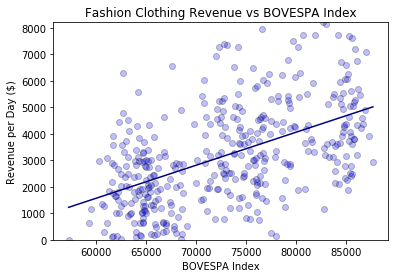

R2 = 0.38
Revenue = 0.181 * (BOVESPA Index) + (-8715.16)


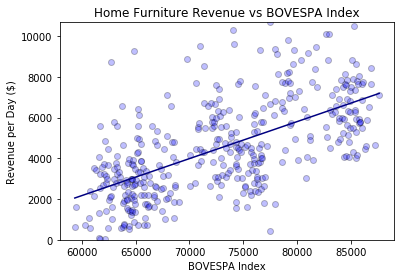

R2 = 0.24
Revenue = 0.053 * (BOVESPA Index) + (-2676.33)


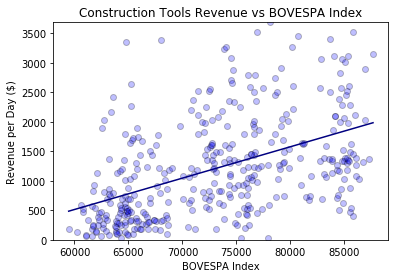

R2 = 0.32
Revenue = 0.141 * (BOVESPA Index) + (-7335.77)


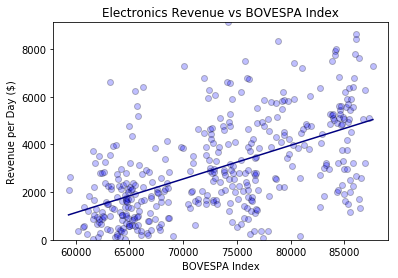

R2 = 0.07
Revenue = 0.004 * (BOVESPA Index) + (-167.18)


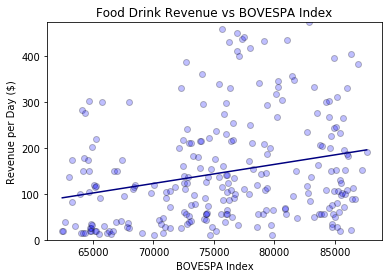

R2 = 0.01
Revenue = 0.001 * (BOVESPA Index) + (43.18)


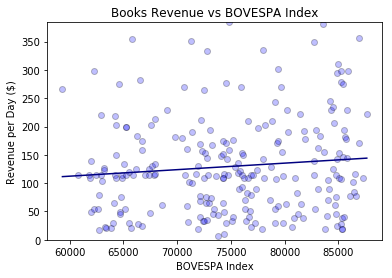

R2 = 0.15
Revenue = 0.031 * (BOVESPA Index) + (-1596.31)


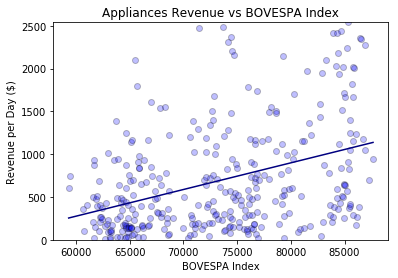

R2 = 0.22
Revenue = 0.043 * (BOVESPA Index) + (-2182.09)


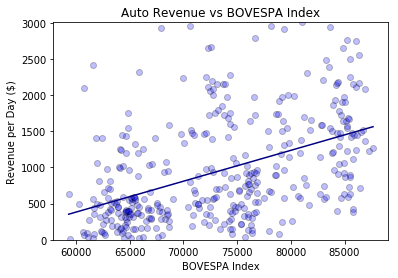

R2 = 0.01
Revenue = 0.006 * (BOVESPA Index) + (-58.64)


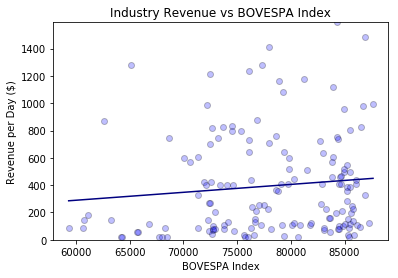

R2 = 0.32
Revenue = 0.175 * (BOVESPA Index) + (-8001.37)


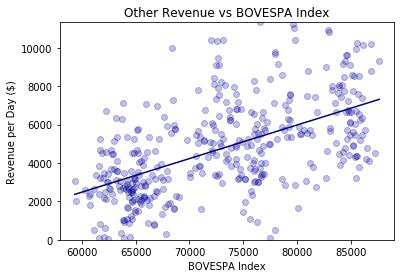

In [13]:
for metric in metriclist:
    for cat in new_categories.keys():
        groupdf = mergedf.groupby([metric, 'category'])
        groupdf = groupdf.sum()
        groupdf.reset_index(inplace = True)

        groupdf = groupdf.loc[groupdf['price'] > 1]
        groupdf = groupdf.loc[groupdf['category'] == cat]
        
        Q1 = np.percentile(groupdf['price'], 25)
        Q3 = np.percentile(groupdf['price'], 75)
        IQR = Q3 - Q1
        UpperBound = Q3 + 1.5 * IQR
        LowerBound = Q1 - 1.5 * IQR
        
        groupdf = groupdf.loc[groupdf['price'] < UpperBound]
        groupdf = groupdf.loc[groupdf['price'] > LowerBound]


        plt.scatter(groupdf[metric], groupdf['price'], color="blue", edgecolor="black", alpha = 0.25,marker="o")
        
        plt.ylim(0, max(groupdf['price']))
        (slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf[metric], groupdf['price'])
        fitBOV = slopeBOV * groupdf[metric] + interceptBOV
        
        plt.ylabel('Revenue per Day ($)')
        plt.xlabel('BOVESPA Index')
        plt.title(f'{cat.replace("_", " ").title()} Revenue vs BOVESPA Index')
        plt.plot(groupdf[metric], fitBOV, color = 'navy')
        print(f'R2 = {round(rBOV**2,2)}')
        print(f'Revenue = {round(slopeBOV, 3)} * (BOVESPA Index) + ({round(interceptBOV,2)})')
        
        plt.savefig(f'./Graphs/{metric}{cat}.png')
        plt.show()

# Show regression for Revenue vs. BOV for total

R2 = 0.51
Revenue = 1.0139 * (BOVESPA Index) + (-51588.97)


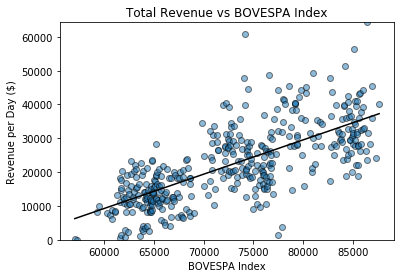

In [14]:
for metric in metriclist:
    groupdf = mergedf.groupby(metric)
    groupdf = groupdf.sum()
    groupdf.reset_index(inplace = True)
    #why are there sum of prices at 0? no data from those dates?
    groupdf = groupdf.loc[groupdf['price'] > 1]


    plt.scatter(groupdf[metric], groupdf['price'], alpha = 0.5, edgecolor = 'black')
    plt.ylim(0, max(groupdf['price']))
    (slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf[metric], groupdf['price'])

    fitBOV = slopeBOV * groupdf[metric] + interceptBOV
    
    plt.plot(groupdf[metric], fitBOV, color = 'black')
    plt.ylabel('Revenue per Day ($)')
    plt.xlabel('BOVESPA Index')
    plt.title('Total Revenue vs BOVESPA Index')
    
    print(f'R2 = {round(rBOV**2,2)}')
    print(f'Revenue = {round(slopeBOV, 4)} * (BOVESPA Index) + ({round(interceptBOV,2)})')
    plt.savefig(f'./Graphs/TotalRevenueVsBOV.png')
    plt.show()
    

# Sum Revenue by Month

In [42]:
newgroup2 = mergedf.groupby(['month'])['BOV'].mean()
newgroup2 = newgroup2[['01/17','02/17','03/17','04/17','05/17','06/17','07/17','08/17','09/17','10/17','11/17','12/17','01/18','02/18','03/18','04/18','05/18','06/18','07/18','08/18','09/18']]
newgroup2.index.rename('Months Jan 17 to Sept 18 ', inplace=True)

newgroup = mergedf.groupby(['category','month'])['price'].sum()
newgroup = newgroup.unstack(level=-1)

newgroup = newgroup[['01/17','02/17','03/17','04/17','05/17','06/17','07/17','08/17','09/17','10/17','11/17','12/17','01/18','02/18','03/18','04/18','05/18','06/18','07/18','08/18','09/18']]

newgroup.columns.rename('Months Jan 17 to Sept 18 ', inplace=True)

newgroup = newgroup.drop(['09/18'], axis=1)

newgroup.head()

Months Jan 17 to Sept 18     01/17     02/17     03/17     04/17     05/17  \
category                                                                     
appliances                 4611.16  11038.68  23442.07  19720.41  11393.94   
auto                       5629.53  13206.70  14578.76  15116.07  18585.04   
books                       284.79    980.81   2723.96   1366.37   1773.47   
construction_tools         8598.65  14858.90  25133.70  22689.13  22872.78   
costruction_tools_garden       NaN    579.98       NaN   1490.21   1577.24   

Months Jan 17 to Sept 18      06/17     07/17     08/17     09/17     10/17  \
category                                                                      
appliances                 15598.45  11376.11  16614.71  16602.68  13864.92   
auto                       32290.69  15456.32  18289.43  15226.07  20788.28   
books                       2281.98   1820.50   4357.18   2471.49   1573.30   
construction_tools         17544.86  21543.16  26235.23  28700.46  33420.83   
costruction_tools_garden     434.69    347.58   1286.19    297.50    746.90   

Months Jan 17 to Sept 18      11/17     12/17     01/18     02/18     03/18  \
category                                                                      
appliances                 18497.81  12205.94  31172.44  26138.97  42187.17   
auto                       31466.98  38073.47  36809.85  42330.67  45297.57   
books                       3099.17   3338.19   3904.70   3644.76   3033.40   
construction_tools         55732.93  40422.00  48244.75  50323.36  49846.12   
costruction_tools_garden    1150.60    928.90   3927.98   1538.25   2497.23   

Months Jan 17 to Sept 18      04/18     05/18     06/18     07/18     08/18  
category                                                                     
appliances                 62834.02  45988.51  34732.67  34224.70  29265.18  
auto                       48852.83  39811.36  45337.18  43812.92  45132.97  
books                       8259.08   8871.05   5532.99   6694.84   3689.77  
construction_tools         65509.44  81974.52  57330.70  57565.52  56595.88  
costruction_tools_garden    1326.79   1121.27    751.45   2836.37   2808.86

# Plot Revenue by Month

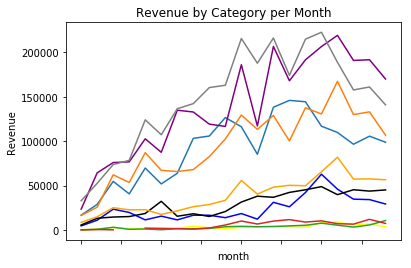

In [39]:
appliances_line = newgroup.iloc[0]
appliances_line.plot(kind='line', color='blue')

auto_line = newgroup.iloc[1]
auto_line.plot(kind='line', color ='black')

books_line = newgroup.iloc[2]
books_line.plot(kind='line', color='yellow')

construction_tools_line = newgroup.iloc[3]
construction_tools_line.plot(kind='line', color='orange')

electronics_line = newgroup.iloc[7]
electronics_line.plot(kind='line')

fashion_clothing_line = newgroup.iloc[8]
fashion_clothing_line.plot(kind='line')

food_drink_line = newgroup.iloc[11]
food_drink_line.plot(kind='line')

home_furniture_line = newgroup.iloc[14]
home_furniture_line.plot(kind='line', color ='purple')

industry_line = newgroup.iloc[15]
industry_line.plot(kind='line')

other_line = newgroup.iloc[16]
other_line.plot(kind='line', color ='gray')

plt.title('Revenue by Category per Month')
plt.ylabel('Revenue')
plt.savefig('./Graphs/CategoricalLineGraph.png')

plt.show()

# Plot BOV Marketcap by Month

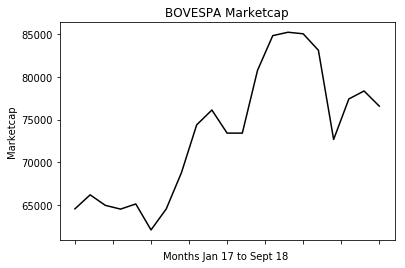

In [40]:
Bov_line = newgroup2
Bov_line.plot(kind='line', color='black')

plt.title('BOVESPA Marketcap')
plt.ylabel('Marketcap')
plt.savefig('./Graphs/BOVESPA_marketcap.png')

plt.show()